Ejercicio 1

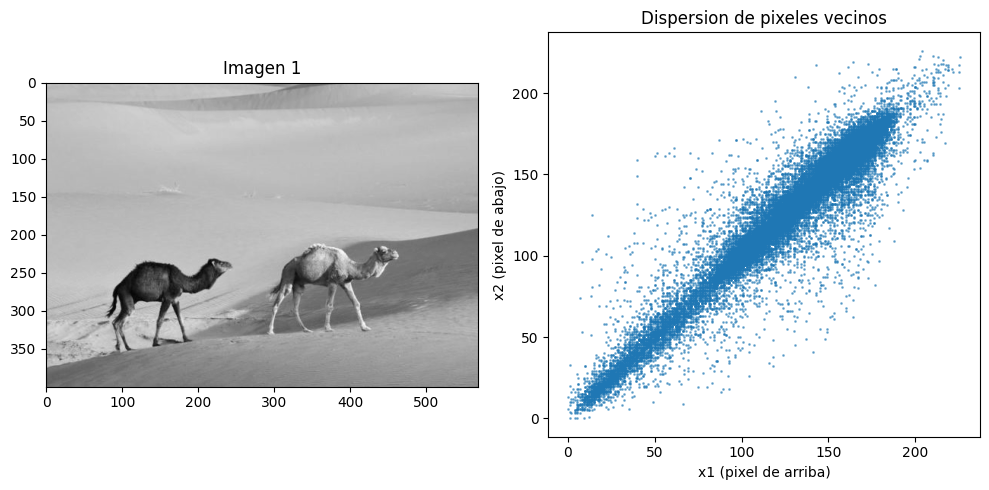

0.9791777913439222


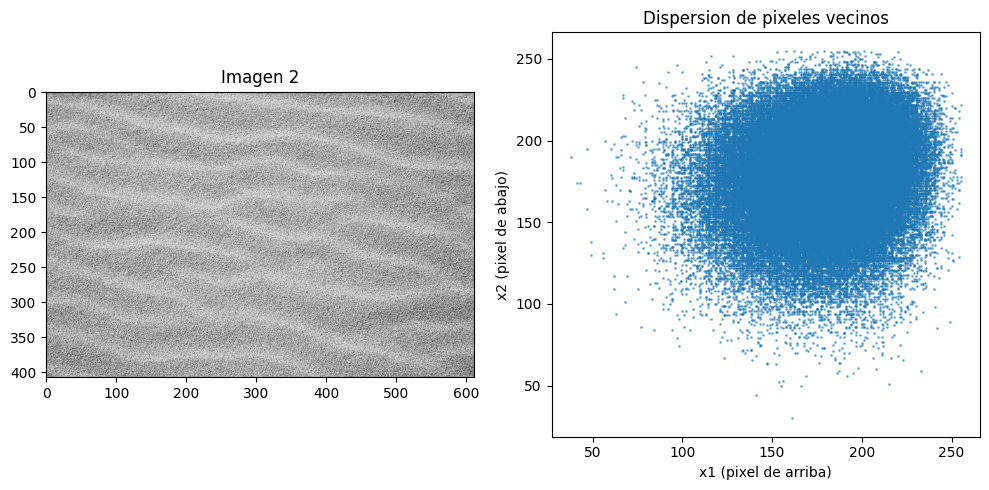

0.1451777791060309


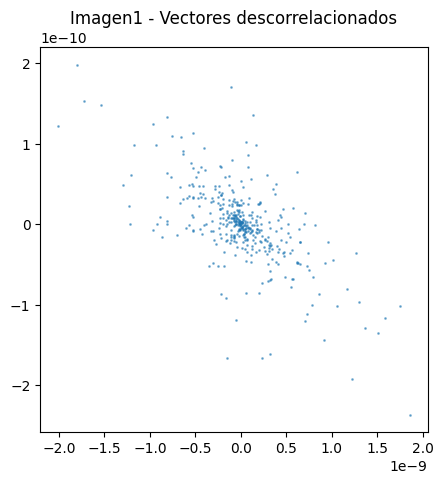

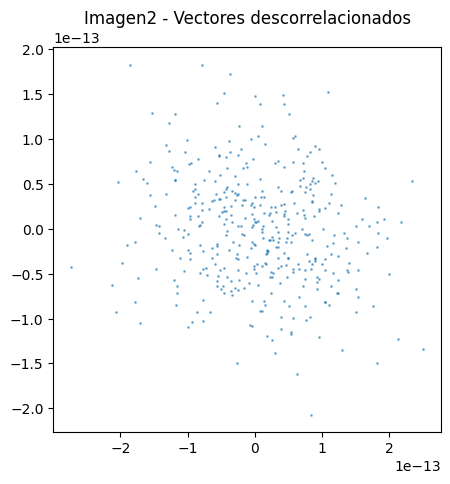

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def img_to_vec(img):
    ImgFloat = img.astype(float)
    ImgVec = ImgFloat.T.ravel()
    x1 = ImgVec[::2]
    x2 = ImgVec[1::2]
    return np.vstack([x1, x2]).T

def graficar(x, img, titulo="Imagen"):
    x1 = x[:,0]
    x2 = x[:,1]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(titulo)

    axes[1].scatter(x1, x2, s=1, alpha=0.5)    
    axes[1].set_xlabel("x1 (pixel de arriba)")   
    axes[1].set_ylabel("x2 (pixel de abajo)") 
    axes[1].set_title("Dispersion de pixeles vecinos")
    
    plt.tight_layout()
    plt.show()

    corr = np.corrcoef(x1, x2) [0, 1]
    print(corr)

def descorrelacion(x):
    mu = x.mean(axis=0)
    x_centrado = x - mu

    cov = np.cov(x_centrado, rowvar=False)

    autoval, autovec = np.linalg.eigh(cov)

    idx = np.argsort(autoval)[::1] #indices de las posiciones ordenadas
    autovec = autovec[:, idx]

    return x_centrado @ autovec #producto entre los datos centrados y los autovectores

def graficar_descorrelacion(x, titulo="Imagen - Vectores descorrelacionados"):
    plt.figure(figsize=(5,5))
    plt.scatter(x[:,0], x[:,1], s=1, alpha=0.5)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(titulo)
    plt.show()


img1 = cv2.imread("img_01.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("img_02.jpg", cv2.IMREAD_GRAYSCALE)

v1 = img_to_vec(img1)
v2 = img_to_vec(img2)

graficar(v1, img1, "Imagen 1")
graficar(v2, img2, "Imagen 2")

d1 = descorrelacion(img1)
d2 = descorrelacion(img2)

graficar_descorrelacion(d1, "Imagen1 - Vectores descorrelacionados")
graficar_descorrelacion(d2, "Imagen2 - Vectores descorrelacionados")

Ejercicio 2

In [2]:
import numpy as np
import cv2

def Escala_de_grises(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

def Separar_en_bloques(matriz_img, tam_bloque):
    bloques=[]
    alto,ancho=matriz_img.shape
    for i in range(0,alto,tam_bloque):
        for j in range(0,ancho, tam_bloque):
            bloque = matriz_img[i:i+tam_bloque, j:j+tam_bloque]
            if bloque.shape == (tam_bloque, tam_bloque):
                bloque=bloque.reshape(-1,1,order='F')
                bloques.append(bloque)
    return np.array(bloques)

def pca_transform(X_centrado,porcentaje_de_espacio):
    _,dim_vector,_ =X_centrado.shape
    k=(porcentaje_de_espacio/100)-1
    k*=-dim_vector
    k=round(k)
    X2D = X_centrado.squeeze(-1)  
    U, S, VT = np.linalg.svd(X2D, full_matrices=False)
    U_k= U[:,:k]
    S_k=np.diag(S[:k])
    VT_k = VT[:k, :]        
    return U_k,S_k,VT_k
    
def comprimir(img_path, tam_bloque):
    Imagen_escalada=Escala_de_grises(img_path)
    X=Separar_en_bloques(Imagen_escalada,tam_bloque)
    Media_X = np.mean(X, axis=1, keepdims=True)  
    X_centrado = X - Media_X
    U_k,S_k,VT_k=pca_transform(X_centrado,80)
    Y_k = U_k @ S_k  
    
    return Y_k, Media_X, VT_k

Ejercicio 3

In [3]:
def descomprimir(matriz_Y_k, Media_X, VT_k):
    Xreconstruida = (np.array(matriz_Y_k) @ np.array(VT_k))[:, :, None] + np.array(Media_X)
    n = Xreconstruida.shape[0]
    X_recon = np.zeros((n, 8, 8))
    for i in range(n):
        X_recon[i] = Xreconstruida[i].reshape(8, 8, order='F')
    
    return X_recon
    
path=r"img_04.jpg"


y,mu,vt=comprimir(path,8)
X_reconstruida = descomprimir(y, mu, vt)

Imagen_escalada = Escala_de_grises(path)
alto, ancho = Imagen_escalada.shape

def recomponer_imagen(bloques, alto, ancho, tam_bloque=8):

    imagen = np.zeros((alto, ancho))
    bloques_por_fila = ancho // tam_bloque
    for idx, bloque in enumerate(bloques):
        fila = (idx // bloques_por_fila) * tam_bloque
        col = (idx % bloques_por_fila) * tam_bloque
        imagen[fila:fila+tam_bloque, col:col+tam_bloque] = bloque
    return imagen
# Reconstruir y mostrar la imagen
img_final = recomponer_imagen(X_reconstruida,alto,ancho,8)
cv2.imshow('Imagen Reconstruida', img_final.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

Ejercicio 4

In [ ]:
from PIL import Image
from IPython.display import display
import cv2

img_vector = cv2. imread('img_04.jpg', cv2. IMREAD_GRAYSCALE)
img = Image.fromarray(img_vector)
display(img)

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- utilidades ----------
def load_gray(path, to_float01=False):
    """Carga imagen en escala de grises. Devuelve np.ndarray."""
    arr = np.array(Image.open(path).convert('L'))
    if to_float01:
        arr = arr.astype(np.float32) / 255.0
    else:
        arr = arr.astype(np.float32)  # escala 0..255 en float
    return arr

def mse(a, b):
    if a.shape != b.shape:
        # Si no coinciden tamaños, recorto a la intersección superior izquierda
        h = min(a.shape[0], b.shape[0])
        w = min(a.shape[1], b.shape[1])
        a = a[:h, :w]
        b = b[:h, :w]
    return float(np.mean((a - b) ** 2))

# ---------- configuración ----------
orig_path = Path("img_04.jpg")             # imagen previa a compresión
recon_pattern = "rec_S{S}.png"             # cambia esto si usaste otro nombre
S_list = list(range(5, 100, 5))            # 5,10,...,95 (lo que pide el 4a)
to_float01 = True                          # poné False si querés MSE en 0..255

# ---------- cálculo y gráfico ----------
orig = load_gray(orig_path, to_float01=to_float01)

Ss, mses = [], []
for S in S_list:
    rpath = Path(recon_pattern.format(S=S))
    if not rpath.exists():
        print(f"[AVISO] No encontré {rpath}, lo salto.")
        continue
    rec = load_gray(rpath, to_float01=to_float01)
    Ss.append(S)
    mses.append(mse(orig, rec))

# Mostrar resultados
for S, e in zip(Ss, mses):
    print(f"S={S:>2d}%  ->  MSE={e:.6f}")

plt.figure()
plt.plot(Ss, mses, marker='o')
plt.xlabel('Ahorro de espacio S [%]')
plt.ylabel('MSE')
plt.title('MSE vs. Ahorro S (usando imágenes original y reconstruidas)')
plt.grid(True)
plt.show()


[AVISO] No encontré rec_S5.png, lo salto.
[AVISO] No encontré rec_S10.png, lo salto.
[AVISO] No encontré rec_S15.png, lo salto.
[AVISO] No encontré rec_S20.png, lo salto.
[AVISO] No encontré rec_S25.png, lo salto.
[AVISO] No encontré rec_S30.png, lo salto.
[AVISO] No encontré rec_S35.png, lo salto.
[AVISO] No encontré rec_S40.png, lo salto.
[AVISO] No encontré rec_S45.png, lo salto.
[AVISO] No encontré rec_S50.png, lo salto.
[AVISO] No encontré rec_S55.png, lo salto.
[AVISO] No encontré rec_S60.png, lo salto.
[AVISO] No encontré rec_S65.png, lo salto.
[AVISO] No encontré rec_S70.png, lo salto.
[AVISO] No encontré rec_S75.png, lo salto.
[AVISO] No encontré rec_S80.png, lo salto.
[AVISO] No encontré rec_S85.png, lo salto.
[AVISO] No encontré rec_S90.png, lo salto.
[AVISO] No encontré rec_S95.png, lo salto.
